In [1]:
# This is always required for inline plot rendering in IPython Notebooks; might
# as well do it first, even before the markdown sections, just to be safe
#%matplotlib inline
%matplotlib notebook

# Average Algorithm - Contents:

This Notebook provides a very brief theoretical basis for the AverageAlgorithm algorithm (there's not very much "theory" involved). More importantly, it serves as a deomonstration and validation study for a real time-optimized USGS Dst index product, which combines the SqDistAlgorithm and AverageAlgorithm into a critical USGS geomagnetic data product.

- [Theoretical Basis](#Theoretical-Basis)
  - [Motivation](#Motivation)
  - [Math and Theory](#Math-and-Theory)
  - [Practical Considerations](#Practical-Considerations)
- [Demonstration and Validation](#Demonstration-and-Validation)
  - [Notebook Functions](#Notebook-Functions)
    - [Imports](#Imports)
  - [24 Hours of Dst4](#24-Hours-of-Dst4)
  - [1 Month of Dst3](#1-Month-of-Dst3)
  - [1 Month of SV and SQ](#1-Month-of-SV-and-SQ)

# [Theoretical Basis](#Average-Algorithm---Contents:)

## [Motivation](#Average-Algorithm---Contents:)

The average algorithm creates an averaged stream from each of the traces in the timeseries that is passed to the algorithm. There are checks to ensure that the traces contain the same channels with the same timestamps but come from different observatories. This is used primarily for creating Dst (Disturbance Storm Time) event data.

## [Math and Theory](#Average-Algorithm---Contents:)

The timeseries that is passed to the average algorithm process is looped over each observatory. The data related to each observatory is compiled into a 2D numpy array. As the data is input to the numpy array it is multiplied by a correctional value that defaults to 1 but can be changed by specifying an average_observatory_scale parameter. The correctional value is a weighting scale that varies from 0-1 in order to place a stronger reliance on certain observatories. The data in the 2D numpy array is then averaged into a single array using numpy's mean function. A new stream is created with this new data using a get_trace function that resets the stats to a new channel, station, network, interval, and location.

## [Practical Considerations](#Average-Algorithm---Contents:)

The averaging function can be called from the command line using the geomag.py script and adding in the optional call to --algorithm average. The algorithm can also be used from your own python script as shown below. This algorithm will take streams of multiple observatories but only one channel may be average at one time. When initializing the algorithm three parameters may be set, observatories, scales, and channel. The observatories and channel may be used as a sort of check to ensure that only the observatories and/or channel you specified are used to create the averaged stream. The scales is used to set the correction factors and must be set in the same order that the observatories are set. Sometimes when using the command line it is necessary to specify the --outchannels argument as some factories, like the iaga writer, will try to set a different outchannel. 

# [Demonstration and Validation](#Average-Algorithm---Contents:)

## [Notebook Functions](#Average-Algorithm---Contents:)

### [Imports](#Average-Algorithm---Contents:)

In [2]:
from geomagio.edge import EdgeFactory
from geomagio.algorithm import AverageAlgorithm, XYZAlgorithm
from obspy.core import UTCDateTime, Stream
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

## [24 Hours of Dst4](#Average-Algorithm---Contents:)

To begin, we look closely at a single 24 hour interval of legacy and new 4-station Dst. To ensure an "apples-to-apples" comparison of just the averaging techniques, the same disturbance values are used as input (namely, those from the legacy USGS Dst algorithm). We do this to highlight a key difference between the AverageAlgorithm's new one-minute Dst, and the USGS's legacy Dst: **The AverageAlgorithm assumes that, if an input is missing, the Dst output at the same time is invalid.**

One might argue in favor of allowing missing inputs in each average. However, when the number of inputs is small, as is the case with the Dst index, a single missing input can impact the output by introducing very visible non-physical baseline shifts. This behavior is demonstrated in the figure below. At midnight UTC, when the real time feed from the KAK observatory experienced a brief dropout, the legacy algorithm simply averaged the remaining 3 stations, resulting in a brief baseline shift in the Dst output. The new Dst algorithm, however, correctly treats this as bad/missing data.

Also visible in the figure below is a baseline shift in the HER disturbance data at \~09:00 UTC. This spike is also visible in both the legacy and new Dst series, albeit muted by a factor of \~0.25. This is because AverageAlgorithm does not detect/remove such spikes, and the bad data is included in the averaging. Similarly, there are what appear to be somewhat longer (\~1 hour) baseline shifts across all the observatory disturbance series (e.g., \~21:00 UTC and \~11:00 UTC). Even though these offsets mostly average out when multiple observatory series are combined, they can still be seen in the Dst output.

In [3]:
# Read in legacy disturbance from 4 traditional Dst stations
channels = ['MSD']
observatories = ['SJG','HON','KAK','HER']
start = UTCDateTime('2018-06-04T12:00:00Z')
end = UTCDateTime('2018-06-05T12:00:00Z')
stream4 = Stream()

input_factory = EdgeFactory(host='cwbpub.cr.usgs.gov')
for obs in observatories:
    stream4 += input_factory.get_timeseries(
        starttime=start,
        endtime=end,
        channels=channels,
        observatory=obs,
        type='variation',
        interval='minute')

In [4]:
# Read in legacy Dst4
channels = ['MGD']
streamDst4 = Stream()

input_factory = EdgeFactory(host='cwbpub.cr.usgs.gov')
streamDst4 = input_factory.get_timeseries(
    starttime=start,
    endtime=end,
    channels=channels,
    observatory='USGS',
    type='variation',
    interval='minute')

In [5]:
# calculate NEW Dst4 using AverageAlgorithm
algo = AverageAlgorithm(observatories = ['SJG', 'HON', 'KAK', 'HER'], 
                        scales = [1/0.994381, 1/0.92959, 1, 1])
streamDst4New = algo.process(stream4)

<IPython.core.display.Javascript object>


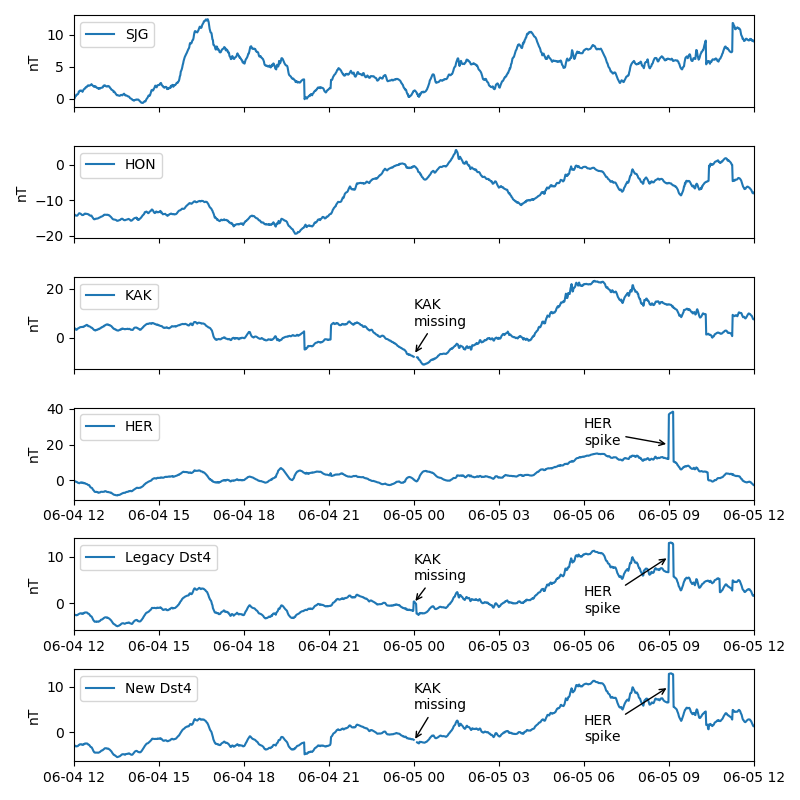

In [6]:
# plot up 4 disturbance traces, then the two Dst traces

# generate list of UTCDateTimes for plotting
utc_arr = np.array([(stream4[0].stats.starttime + second) 
                    for second in stream4[0].times()])
dt_arr = [utc.datetime for utc in utc_arr]

# plot disturbance traces
plt.figure(figsize=(8,8))
plt.subplot(611)
plt.plot(dt_arr, stream4[0].data)
plt.xlim([dt_arr[0], dt_arr[-1]])
plt.legend([stream4[0].stats.station], loc='upper left')
plt.ylabel('nT')
plt.gca().set_xticklabels([])

plt.subplot(612)
plt.plot(dt_arr, stream4[1].data)
plt.xlim([dt_arr[0], dt_arr[-1]])
plt.legend([stream4[1].stats.station], loc='upper left')
plt.ylabel('nT')
plt.gca().set_xticklabels([])

plt.subplot(613)
plt.plot(dt_arr, stream4[2].data)
plt.xlim([dt_arr[0], dt_arr[-1]])
plt.legend([stream4[2].stats.station], loc='upper left')
plt.ylabel('nT')
plt.annotate('KAK\nmissing', (dt_arr[720], -7), (dt_arr[720], 5), 
             arrowprops={'arrowstyle':'->'})
plt.gca().set_xticklabels([])

plt.subplot(614)
plt.plot(dt_arr, stream4[3].data)
plt.xlim([dt_arr[0], dt_arr[-1]])
plt.legend([stream4[3].stats.station], loc='upper left')
plt.annotate('HER\nspike', (dt_arr[1260], 20), (dt_arr[1080], 20), 
             arrowprops={'arrowstyle':'->'})
plt.ylabel('nT')

plt.subplot(615)
plt.plot(dt_arr, streamDst4[0].data)
plt.xlim([dt_arr[0], dt_arr[-1]])
plt.legend(['Legacy Dst4'], loc='upper left')
plt.ylabel('nT')
plt.annotate('KAK\nmissing', (dt_arr[720], 0), (dt_arr[720], 5), 
             arrowprops={'arrowstyle':'->'})
plt.annotate('HER\nspike', (dt_arr[1260], 10), (dt_arr[1080], -2), 
             arrowprops={'arrowstyle':'->'})

plt.subplot(616)
plt.plot(dt_arr, streamDst4New[0].data)
plt.xlim([dt_arr[0], dt_arr[-1]])
plt.legend(['New Dst4'], loc='upper left')
plt.ylabel('nT')
plt.annotate('KAK\nmissing', (dt_arr[720], -2), (dt_arr[720], 5), 
             arrowprops={'arrowstyle':'->'})
plt.annotate('HER\nspike', (dt_arr[1260], 10), (dt_arr[1080], -2), 
             arrowprops={'arrowstyle':'->'})

plt.tight_layout()

## [1 Month of Dst3](#Average-Algorithm---Contents:)

If one were to examine the actual H measurements (that is, before the removal of secular variation (SV) and solar quiet (SQ) baselines), none of the baseline shifts noted previously are apparent. This indicates a flaw or flaws in the legacy algorithm's SV and SQ removal routines. While this document is not intended to demonstrate or re-validate the SQDistAlgorithm (the newer tool used extract "disturbance" from measured data), it is worth looking at a longer interval to assess the quality of the new Dst algorithm relative to the legacy algorithm.

To this end, we look at a month of legacy and new 3-station Dst. Here the goal is not necessarily an "apples-to-apples" comparison of the different averaging techniques, just one component of the respective Dst algorithms, but rather to provide an high-level comparison of the two Dst algorithms as run in real time operations. The interval below was chosen because 1) it contained a geomagnetic storm, and 2) all observatories were operating more-or-less nominally.

Overall, the two Dst traces follow each other quite closely, with a 0.95 correlation estimated for this interval. There are numerous seemingly random deviations of the legacy Dst from the new Dst output, and if one zooms in, it can be seen that most of these are the non-physical baseline shifts noted previously. There is also a weak diurnal signal in the difference between the two traces . Neither algorithm is able to remove the diurnal SQ signal perfectly. However, noting that the legacy algorithm uses a Fourier Transform of the previous 6 months of measurements, while the new algorithm has a "memory" of only 30 days, it is perhaps reasonable to assume that the new algorithm is doing a better job of capturing the continually evolving diurnal SQ signal during this interval.

These, however, are rather minor discrepancies. A major discrepancy, one that suggests a significant error in the legacy Dst trace, is the delayed drop in the GUA disturbance series as the geomagnetic storm ramps up during the early hours (UTC) on the 26th of August. This discrepancy is muted in the final Dst trace, but still quite obvious, especially when one zooms in on the storm. It is also unclear why the legacy algorithm produces magnetic disturbance values for GUA between 12:00 on September 10th, and 12:00 on September 11th, when this is a known gap in the historical archives.

In conclusion, the new USGS Dst algorithm (a combination of SQDistAlgorithm and AverageAlgorithm) offers a reliable real-time, high-resolution alternative to the traditional Dst index.

In [7]:
# Read in legacy production disturbance for Dst3 stations
channels = ['MSD']
observatories = ['SJG', 'HON', 'GUA']
start = UTCDateTime('2018-08-16T00:00:00Z')
end = UTCDateTime('2018-09-15T00:00:00Z')
stream3plusDst3Legacy = Stream()
stream3MVH = Stream()

input_factory = EdgeFactory(host='cwbpub.cr.usgs.gov')
for obs in observatories:
    stream3plusDst3Legacy += input_factory.get_timeseries(
        starttime=start,
        endtime=end,
        channels=channels,
        observatory=obs,
        type='variation',
        interval='minute')

# Read in actual legacy Dst3 calculated in real time
stream3plusDst3Legacy += input_factory.get_timeseries(
    starttime=start,
    endtime=end,
    channels=['MGD'],
    observatory='USGS',
    type='variation',
    interval='minute')

#stream3plusDst3Legacy.plot()
 
# Turns out GUA disturbance was never stored on Edge, but we can reconstruct 
# it given that we know what the scale factors were
gua_array = (3 * stream3plusDst3Legacy.select(station='USGS')[0].data - \
             (.994381 * stream3plusDst3Legacy.select(station='SJG')[0].data + \
              .92959 * stream3plusDst3Legacy.select(station='HON')[0].data)) / .9999
    
stream3plusDst3Legacy.select(station='GUA')[0].data = gua_array

read_wave_server_v returned flag FG - requested data lie in tank gap


In [8]:
# Read in new production disturbance for Dst3 stations
channels = ['MDT']
observatories = ['SJG', 'HON', 'GUA']
start = UTCDateTime('2018-08-16T00:00:00Z')
end = UTCDateTime('2018-09-15T00:00:00Z')
stream3plusDst3New = Stream()

input_factory = EdgeFactory(host='cwbpub.cr.usgs.gov')
for obs in observatories:
    stream3plusDst3New += input_factory.get_timeseries(
        starttime=start,
        endtime=end,
        channels=channels,
        observatory=obs,
        type='variation',
        interval='minute')

# # Read in actual new Dst3 calculated in real time
# stream3plusDst3New += input_factory.get_timeseries(
#     starttime=start,
#     endtime=end,
#     channels=['UX3'],
#     observatory='USGS',
#     type='variation',
#     interval='minute')

algo = AverageAlgorithm(observatories = ['SJG', 'HON', 'GUA'], 
                        scales = [1/0.994381, 1/0.92959, 1/.9999])
stream3plusDst3New += algo.process(stream3plusDst3New)


#stream3plusDst3New.plot()

In [9]:
# calculate correlation coefficient, allowing for gaps
np.ma.corrcoef(np.ma.masked_invalid(stream3plusDst3Legacy[3].data), 
               np.ma.masked_invalid(stream3plusDst3New[3].data))

masked_array(data =
 [[1.0 0.9542974361058707]
 [0.9542974361058707 1.0]],
             mask =
 [[False False]
 [False False]],
       fill_value = 1e+20)

<IPython.core.display.Javascript object>


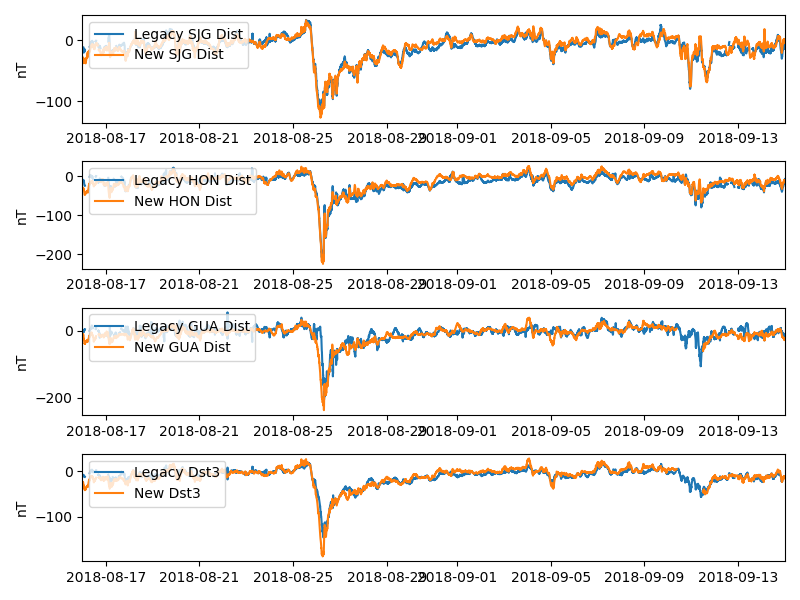

In [10]:
# plot up 3 disturbance traces, then the Dst traces

# generate list of UTCDateTimes for plotting
utc_arr = np.array([(stream3plusDst3Legacy[0].stats.starttime + second) 
                    for second in stream3plusDst3Legacy[0].times()])
dt_arr = [utc.datetime for utc in utc_arr]

# plot disturbance traces
plt.figure(figsize=(8,6))

plt.subplot(411)
plt.plot(dt_arr, stream3plusDst3Legacy[0].data)
plt.plot(dt_arr, stream3plusDst3New[0].data)
plt.xlim([dt_arr[0], dt_arr[-1]])
plt.legend(['Legacy SJG Dist', 'New SJG Dist'], loc='upper left')
plt.ylabel('nT')
# plt.gca().set_xticklabels([])

plt.subplot(412)
plt.plot(dt_arr, stream3plusDst3Legacy[1].data)
plt.plot(dt_arr, stream3plusDst3New[1].data)
plt.xlim([dt_arr[0], dt_arr[-1]])
plt.legend(['Legacy HON Dist', 'New HON Dist'], loc='upper left')
plt.ylabel('nT')
# plt.gca().set_xticklabels([])

plt.subplot(413)
plt.plot(dt_arr, stream3plusDst3Legacy[2].data)
plt.plot(dt_arr, stream3plusDst3New[2].data)
plt.xlim([dt_arr[0], dt_arr[-1]])
plt.legend(['Legacy GUA Dist', 'New GUA Dist'], loc='upper left')
plt.ylabel('nT')
# plt.gca().set_xticklabels([])


plt.subplot(414)
plt.plot(dt_arr, stream3plusDst3Legacy[3].data)
plt.plot(dt_arr, stream3plusDst3New[3].data)
plt.xlim([dt_arr[0], dt_arr[-1]])
plt.legend(['Legacy Dst3', 'New Dst3'], loc='upper left')
plt.ylabel('nT')

plt.tight_layout()

## [1 Month of SV and SQ](#Average-Algorithm---Contents:)

The previous figures were of observatory-specific magnetic disturbance and Dst. For context, the sum of secular variation (SV) and solar quiet (SQ) baselines, which was removed to generate disturbance, are plotted below for both the legacy and new Dst algorithms. Also plotted are the original magnetic H observations. There is an inordinate amount of high frequency noise in the legacy baselines that cannot be easily explained, although it must be acknowledged that the new algorithm specifically smooths variations with periods less than 3 hours. This does **NOT** explain the large discrepancy noted previously for GUA at the beginning of the storm.

In [11]:
# retrieve the Hs used by each respective algorithm,
# just to be thorough (they shouldn't differ by much)
streamHEZ = Stream()
stream3Hmag = Stream()
stream3Hobs = Stream()
XYZalgo = XYZAlgorithm(informat='obs', outformat='mag')
for obs in observatories:
    streamHEZ = input_factory.get_timeseries(
        starttime=start,
        endtime=end,
        channels=['H', 'E', 'Z'],
        observatory=obs,
        type='variation',
        interval='minute')
    
    # total horizontal intensity
    stream3Hmag += XYZalgo.process(streamHEZ).select(channel='H')
    
    # h component of magnetometer
    stream3Hobs += streamHEZ.select(channel='H')

<IPython.core.display.Javascript object>


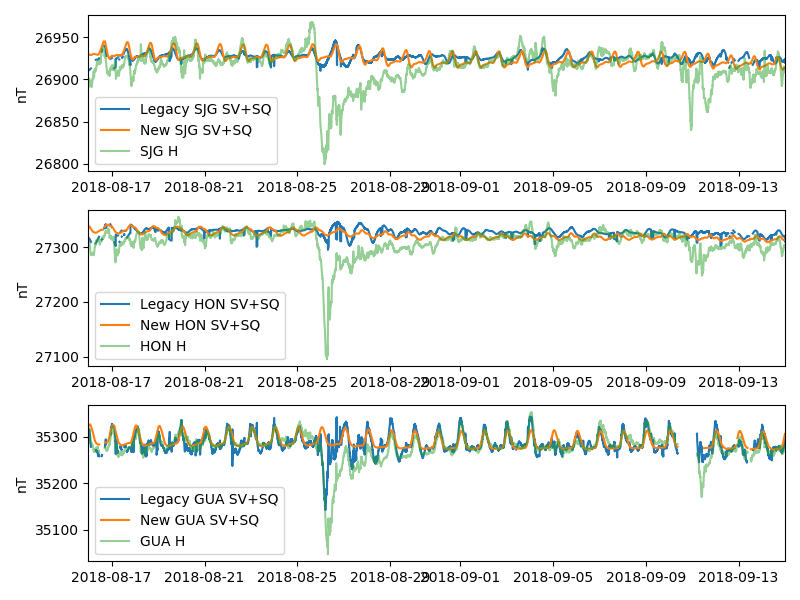

In [12]:
# plot up 3 SV+SQ traces, then overplot full H magnetic field

# generate list of UTCDateTimes for plotting
utc_arr = np.array([(stream3plusDst3Legacy[0].stats.starttime + second) 
                    for second in stream3plusDst3Legacy[0].times()])
dt_arr = [utc.datetime for utc in utc_arr]

# plot disturbance traces
plt.figure(figsize=(8,6))

plt.subplot(311)
plt.plot(dt_arr, stream3Hobs[0].data - stream3plusDst3Legacy[0].data)
plt.plot(dt_arr, stream3Hmag[0].data - stream3plusDst3New[0].data)
plt.plot(dt_arr, stream3Hmag[0].data, alpha=0.5)
plt.xlim([dt_arr[0], dt_arr[-1]])
plt.legend(['Legacy SJG SV+SQ', 'New SJG SV+SQ', 'SJG H'], loc='lower left')
plt.ylabel('nT')
# plt.gca().set_xticklabels([])

plt.subplot(312)
plt.plot(dt_arr, stream3Hobs[1].data - stream3plusDst3Legacy[1].data)
plt.plot(dt_arr, stream3Hmag[1].data - stream3plusDst3New[1].data)
plt.plot(dt_arr, stream3Hmag[1].data, alpha=0.5)
plt.xlim([dt_arr[0], dt_arr[-1]])
plt.legend(['Legacy HON SV+SQ', 'New HON SV+SQ', 'HON H'], loc='lower left')
plt.ylabel('nT')
# plt.gca().set_xticklabels([])

plt.subplot(313)
plt.plot(dt_arr, stream3Hobs[2].data - stream3plusDst3Legacy[2].data)
plt.plot(dt_arr, stream3Hmag[2].data - stream3plusDst3New[2].data)
plt.plot(dt_arr, stream3Hmag[2].data, alpha=0.5)
plt.xlim([dt_arr[0], dt_arr[-1]])
plt.legend(['Legacy GUA SV+SQ', 'New GUA SV+SQ', 'GUA H'], loc='lower left')
plt.ylabel('nT')
# plt.gca().set_xticklabels([])


plt.tight_layout()